In [1]:
import pysam
import pandas as pd
import io
import os
import glhap_app
import random
import matplotlib.pyplot as plt
import numpy as np
import subprocess

In [2]:
def get_mean_depth(fn):
    stats = pd.read_csv(io.StringIO(subprocess.check_output(['samtools', 'coverage', fn]).decode()), sep="\t").iloc[0]
    assert(stats[0] == 'chrM')
    mean_depth = stats[6]
    return mean_depth

In [3]:
get_mean_depth('in1.bam')

4577.44

In [4]:
def downsample(fn, depth, original_depth=None):
    if original_depth == None:
        original_depth = get_mean_depth(fn)
    prop = depth/original_depth
    os.system(f'samtools view -b -s {prop + random.randint(1,1000)} {fn} > {fn[:-4]}.cov_{depth}.bam')

In [5]:
def haplogrep_result(vcf_fn):
    os.system(f'haplogrep classify --input {vcf_fn} --output {vcf_fn[:-7]}.haplogrep.txt --format vcf > /dev/null')
    with open(f'{vcf_fn[:-7]}.haplogrep.txt') as f:
        s =f.readlines()
    s = s[1].replace('"','').split('\t')[1].replace(' ','')
    
    return s

In [6]:
def glhap_results(vcf_fn):
    s = glhap_app.glhap('refchrm.fa', 'array/array.json', f'{vcf_fn}' )
    s = s.splitlines()[1].split('|')[0].replace(' ','')
    return s

In [40]:
files = [
'HGDP00879.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00880.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00881.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00882.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00883.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00884.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00885.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00886.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00888.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00889.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00890.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00891.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00892.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00893.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00894.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00895.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00896.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00897.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00898.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00899.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00900.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00901.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
'HGDP00902.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam',
]

In [7]:
def f(fn):
    pysam.index(fn)
    # individual = fn[:9]
    individual = fn[:3]
    if os.path.exists(individual) == False:
        os.mkdir(individual)
    stats = pd.read_csv(io.StringIO(pysam.coverage(fn)), sep="\t").iloc[0]
    assert(stats[0] == 'chrM')
    mean_depth = stats[6]
    stats_list = []
    for depth in depth_list:
        cut_rate = depth/mean_depth
        os.system(f'samtools view -b -s {cut_rate+np.ran} {fn} > {individual}/cov_{depth}.bam')
        df = pd.read_csv(io.StringIO(pysam.coverage(f'{individual}/cov_{depth}.bam')), sep="\t").iloc[0]
        df[0] =  f'{individual}/cov_{depth}'
        stats_list.append(df)
        df = pd.DataFrame(stats_list).reset_index(drop=True)
        df.to_csv(f'{individual}/stats.csv')
    return df
    
        

In [8]:
def haplogrep_calc(fn):
    os.system(f'bcftools mpileup -Oz -f refchrm.fa {fn} > {fn[:-4]}.mpileup.vcf.gz 2>/dev/null')
    os.system(f'bcftools index {fn[:-4]}.mpileup.vcf.gz 2>/dev/null')
    os.system(f'bcftools call -m -Oz {fn[:-4]}.mpileup.vcf.gz > {fn[:-4]}.call.vcf.gz 2>/dev/null')
    os.system(f'haplogrep classify --input {fn[:-4]}.call.vcf.gz --output {fn[:-4]}.haplogrep.txt --format vcf > /dev/null')
    print("Haplogrep| GLHAP")
    with open(f'{fn[:-4]}.haplogrep.txt') as f:
        s1 =f.readlines()
    s1 = s1[1].replace('"','').split('\t')[1].replace(' ','')
    # print(s1)
    print('haplogrep|glhap')
    s2 = glhap_app.glhap('refchrm.fa', 'array/array.json', f'{fn[:-4]}.mpileup.vcf.gz' )
    s2 = s2.splitlines()[1].split('|')[0].replace(' ','')
    # print(s2)
    if s1==s2:
        print(s1, '=', s2)
        return 1
    else:
        print(s1, '!=', s2)
        
    return 0
    

In [9]:
def get_glhap_accuracy(fn, depth, iterations=100):
    os.system(f'bcftools mpileup -Oz -f refchrm.fa {fn} > {fn[:-4]}.mpileup.vcf.gz 2>/dev/null')
    os.system(f'bcftools index {fn[:-4]}.mpileup.vcf.gz 2>/dev/null')
    os.system(f'bcftools call -m -Oz {fn[:-4]}.mpileup.vcf.gz > {fn[:-4]}.call.vcf.gz 2>/dev/null')
    
    true_haplogroup = haplogrep_result(f'{fn[:-4]}.call.vcf.gz')
    coinc = 0
    original_depth = get_mean_depth(fn)
    for i in range(iterations):
        downsample(fn, depth, original_depth)
        fn_down = f'{fn[:-4]}.cov_{depth}.bam'
        os.system(f'bcftools mpileup -Oz -f refchrm.fa {fn_down} > {fn_down[:-4]}.mpileup.vcf.gz 2>/dev/null')
        os.system(f'bcftools index {fn_down[:-4]}.mpileup.vcf.gz 2>/dev/null')
        hap = glhap_results(f'{fn_down[:-4]}.mpileup.vcf.gz')
        if hap==true_haplogroup:
            coinc +=1
    return coinc / iterations


def get_haplogrep_accuracy(fn, depth, iterations=100):
    os.system(f'bcftools mpileup -Oz -f refchrm.fa {fn} > {fn[:-4]}.mpileup.vcf.gz 2>/dev/null')
    os.system(f'bcftools index {fn[:-4]}.mpileup.vcf.gz 2>/dev/null')
    os.system(f'bcftools call -m -Oz {fn[:-4]}.mpileup.vcf.gz > {fn[:-4]}.call.vcf.gz 2>/dev/null')
    
    true_haplogroup = haplogrep_result(f'{fn[:-4]}.call.vcf.gz')
    coinc = 0
    original_depth = get_mean_depth(fn)
    for i in range(iterations):
        downsample(fn, depth, original_depth)
        fn_down = f'{fn[:-4]}.cov_{depth}.bam'
        os.system(f'bcftools mpileup -Oz -f refchrm.fa {fn_down} > {fn_down[:-4]}.mpileup.vcf.gz 2>/dev/null')
        os.system(f'bcftools index {fn_down[:-4]}.mpileup.vcf.gz 2>/dev/null')
        os.system(f'bcftools call -m -Oz {fn_down[:-4]}.mpileup.vcf.gz > {fn_down[:-4]}.call.vcf.gz 2>/dev/null')
        hap = haplogrep_result(f'{fn_down[:-4]}.call.vcf.gz')
        if hap==true_haplogroup:
            coinc +=1
    return coinc / iterations
        
        
        
    

In [187]:
depths = [0.1 + 0.1 * i for i in range(0,20)]
depths

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2000000000000002,
 1.3000000000000003,
 1.4000000000000001,
 1.5000000000000002,
 1.6,
 1.7000000000000002,
 1.8000000000000003,
 1.9000000000000001,
 2.0]

In [9]:
def get_accuracy_graph(fn, iterations=10):
    ys_glhap = []
    ys_haplogrep = []
    for d in depths:
        ys_glhap.append(get_glhap_accuracy(fn, d, iterations))
        ys_haplogrep.append(get_haplogrep_accuracy(fn, d, iterations))
    plt.plot(depths, ys_glhap, label = 'Glhap')
    plt.plot(depths, ys_haplogrep, label = 'Haplogrep')
    plt.legend()
    plt.show()
    np.savetxt(f'{fn[:-4]}.glhap.txt', [depths, ys_glhap])
    np.savetxt(f'{fn[:-4]}.haplogrep.txt', [depths, ys_glhap])
    

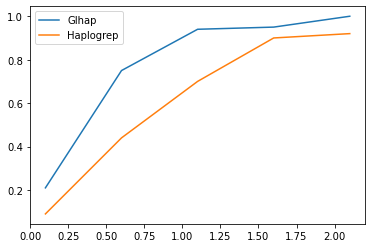

In [184]:
get_accuracy_graph('in1.bam', 100)

In [173]:
f = np.loadtxt('in1.glhap.txt')

In [174]:
g = np.loadtxt('in1.haplogrep.txt')

In [166]:
f

array([[0.1, 0.6, 1.1, 1.6, 2.1],
       [0.5, 1. , 1. , 1. , 1. ]])

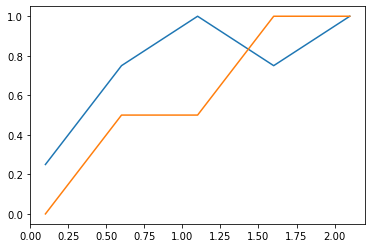

In [175]:
plt.plot(f[0],f[1])
plt.plot(g[0],g[1])

<AxesSubplot:>

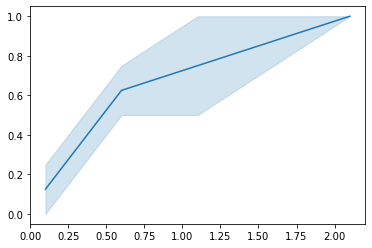

In [183]:
sns.lineplot(x=np.concatenate([f[0],g[0]]), y=np.concatenate([f[1],g[1]]))

In [10]:
haplogrep_calc('HGDP00900.alt_bwamem_GRCh38DH.20181023.Russian.cram.bam')

Haplogrep| GLHAP
haplogrep|glhap
H2a2b != mt-MRCA(RSRS)


0

In [10]:
haplogrep_calc('in1.bam')

Haplogrep| GLHAP
haplogrep|glhap
Haplogroup     |	PL score       
X2b5           |	-535.4         
X2b            |	-611.9         
X2b4           |	-611.9         
X2b7           |	-611.9         
X2b8           |	-611.9         
X2b9           |	-611.9         
X2b1           |	-637.4         
X2b3           |	-637.4         

X2b5 = X2b5


1